In [67]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

from data import FloodEventDataset
from utils import file_utils, plot_utils

### Dataset Visualization

In [68]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [69]:
mode = 'test' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
dataset = FloodEventDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_shp_file=dataset_parameters['nodes_shp_file'],
    edges_shp_file=dataset_parameters['edges_shp_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
)

No previous event stats found. Processing dataset.
Processing Flood Event Dataset...
Saved constant values to data\datasets\processed\constant_values.npz
Saved dynamic values for event 38 to data\datasets\processed\dynamic_values_event_38.npz
Saved dynamic values for event 39 to data\datasets\processed\dynamic_values_event_39.npz
Saved dynamic values for event 40 to data\datasets\processed\dynamic_values_event_40.npz
Saved dynamic values for event 41 to data\datasets\processed\dynamic_values_event_41.npz
Saved event stats to data\datasets\processed\test_event_stats.yaml
Saved boundary condition info to data\datasets\processed\boundary_condition_masks.npz


In [70]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 4
Total number of timesteps: 2296


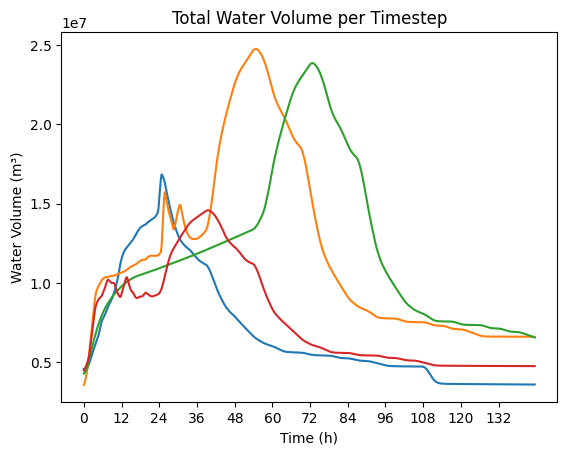

In [71]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]

longest_hours_elapsed = []
for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes'][1:]  # Skip the first timestep as this is only used for previous timestep data
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index(FloodEventDataset.NODE_TARGET_FEATURE)
    water_volume = dynamic_nodes[start_ts:end_ts, :, water_volume_idx]
    water_volume = dataset.normalizer.denormalize(FloodEventDataset.NODE_TARGET_FEATURE, water_volume)
    total_water_volume = water_volume.sum(axis=1)
    hours_elapsed = np.arange(len(total_water_volume)) * delta_t_in_hours
    plt.plot(hours_elapsed, total_water_volume, label=f'Run {run_id}')
    if len(hours_elapsed) > len(longest_hours_elapsed):
        longest_hours_elapsed = hours_elapsed

tick_interval_in_hours = 12
plt.title(f'Total Water Volume per Timestep')
plt.xlabel('Time (h)')
interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
plt.xticks(longest_hours_elapsed[interval_ticks])
plt.ylabel('Water Volume (m³)')
# plt.legend()
plt.show()

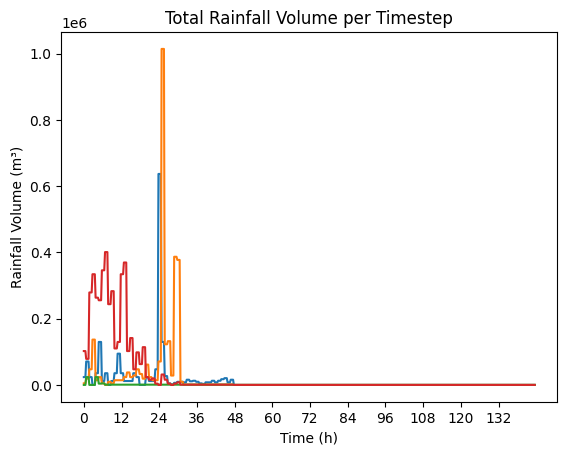

In [72]:
for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_nodes_paths):
    dynamic_nodes = np.load(path)['dynamic_nodes'][1:]  # Skip the first timestep as this is only used for previous timestep data
    rainfall_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('rainfall')
    rainfall = dynamic_nodes[start_ts:end_ts, :, rainfall_idx]
    rainfall = dataset.normalizer.denormalize('rainfall', rainfall)
    total_rainfall = rainfall.sum(axis=1)
    hours_elapsed = np.arange(len(total_water_volume)) * delta_t_in_hours
    plt.plot(hours_elapsed, total_rainfall, label=f'Run {run_id}')

tick_interval_in_hours = 12
plt.title(f'Total Rainfall Volume per Timestep')
plt.xlabel('Time (h)')
interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
plt.xticks(longest_hours_elapsed[interval_ticks])
plt.ylabel('Rainfall Volume (m³)')
# plt.legend()
plt.show()

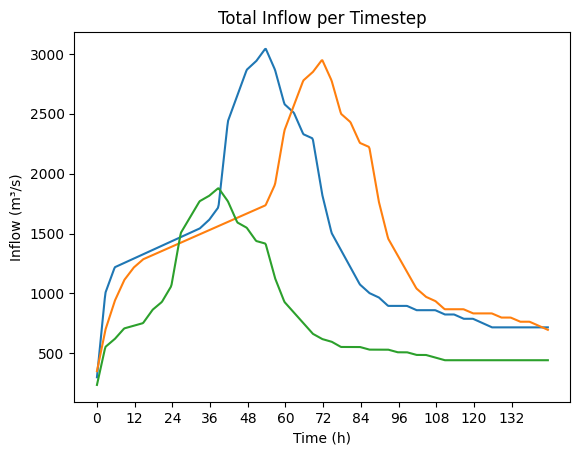

In [73]:
dynamic_edges_paths = dataset.processed_paths[5:(num_events + 4)]
inflow_edge_mask = dataset.boundary_condition.inflow_edges_mask

for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_edges_paths):
    dynamic_edges = np.load(path)['dynamic_edges'][1:]  # Skip the first timestep as this is only used for previous timestep data
    water_flow_idx = FloodEventDataset.DYNAMIC_EDGE_FEATURES.index('face_flow')
    inflow_edges_flow = dynamic_edges[start_ts:end_ts, inflow_edge_mask, water_flow_idx].squeeze()
    inflow_edges_flow = dataset.normalizer.denormalize('face_flow', inflow_edges_flow)
    hours_elapsed = np.arange(len(total_water_volume)) * delta_t_in_hours
    plt.plot(hours_elapsed, inflow_edges_flow, label=f'Run {run_id}')

tick_interval_in_hours = 12
plt.title(f'Total Inflow per Timestep')
plt.xlabel('Time (h)')
interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
plt.xticks(longest_hours_elapsed[interval_ticks])
plt.ylabel('Inflow (m³/s)')
# plt.legend()
plt.show()

In [74]:
event_end_idx = [*dataset.event_start_idx[1:], dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx, prepend=0)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 38 - Event Size: 574 timesteps
Run 39 - Event Size: 574 timesteps
Run 40 - Event Size: 574 timesteps
Run 41 - Event Size: 574 timesteps


Nodes with the highest water volume difference:
Node 1023: 278683.12 m
Node 1022: 262142.62 m
Node 1082: 257740.58 m
Node 329: 255640.78 m
Node 208: 251856.36 m


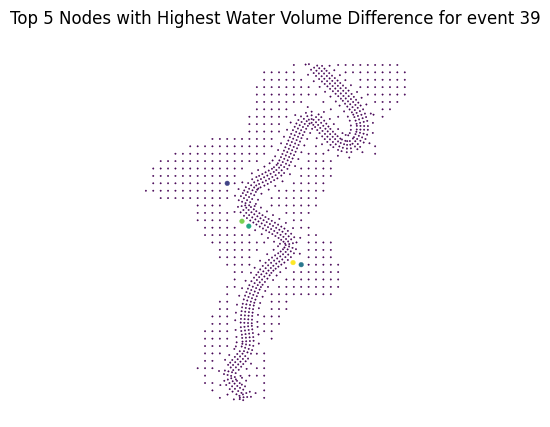

In [75]:
def get_highest_diff_water_volume_nodes(dataset: FloodEventDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_nodes = np.load(dynamic_nodes_paths[event_idx])['dynamic_nodes']
    water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index(FloodEventDataset.NODE_TARGET_FEATURE)
    water_volume = dynamic_nodes[:, :, water_volume_idx]
    water_volume = dataset.normalizer.denormalize(FloodEventDataset.NODE_TARGET_FEATURE, water_volume)
    wv_diff = np.abs(np.diff(water_volume, axis=0))
    wv_diff_per_node = wv_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wv_diff_per_node)[-k:][::-1].tolist()
    top_k_wd_diff = wv_diff_per_node[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff

def get_node_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
    nodes_shp_path = dataset.raw_paths[0]
    node_df = gpd.read_file(nodes_shp_path)

    if no_ghost:
        node_df = node_df[~node_df['CC_index'].isin(dataset.boundary_condition.ghost_nodes)]

    return node_df

def plot_cell_map(node_df: gpd.GeoDataFrame, value: np.ndarray=None, cmap=None, legend: bool=False):
    default_marker_size = 1
    shared_plot_kwargs = {
        'linewidth': 0.3,
        'markersize': default_marker_size,
    }

    if value is not None:
        value_column = 'is_flooded'
        node_df[value_column] = value
        if cmap is None:
            cmap = plt.get_cmap('seismic_r') 
        markersize = (value.astype(bool).astype(int) * 10) + default_marker_size
        shared_plot_kwargs.update({
            'markersize': markersize,
            'cmap': cmap,
            'column': value_column,
            'legend': legend,
            'legend_kwds': {
                'loc': 'lower right',
                'fontsize': 'x-small',
            },
        })

    node_df.plot(**shared_plot_kwargs)
    plt.axis('off')

EVENT_IDX = 1  # Change this to the desired event index
k = 5  # Number of top nodes to retrieve

top_k_diff_idx, top_k_wd_diff = get_highest_diff_water_volume_nodes(dataset, EVENT_IDX, k=k)
print('Nodes with the highest water volume difference:')
for idx, wd in zip(top_k_diff_idx, top_k_wd_diff):
    print(f"Node {idx}: {wd:.2f} m")

node_df = get_node_df(dataset)
highlight = np.zeros(len(node_df), dtype=object)
highlight[top_k_diff_idx] = top_k_diff_idx

plot_cell_map(node_df, value=highlight, cmap='viridis')
plt.title(f'Top {k} Nodes with Highest Water Volume Difference for event {dataset.hec_ras_run_ids[EVENT_IDX]}')
plt.show()

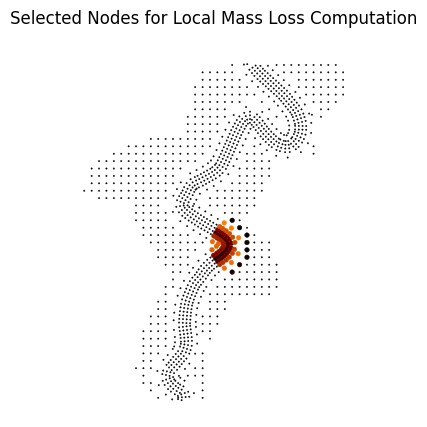

In [89]:
# highlight_node_idx = [534, 644, 626, 463]
highlight_node_idx = [
    772, 771, 770, 769, 768, 767, 766, 765, 764, 763, 762,
    490, 489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 479,
    632, 631, 630, 629, 628, 627, 626, 625, 624, 623, 622, 621,
    912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902, 901,
    1086, 1085, 1084, 1083, 1082, 1081,
    276, 283, 292, 302, 312, 321, 329, 337,
    1018, 1017, 1016, 1015, 
]
highlight = np.zeros(len(node_df), dtype=object)
highlight[highlight_node_idx] = highlight_node_idx

cmap = plot_utils.get_trimmed_cmap('afmhot', 0, 0.5)
plot_cell_map(node_df, value=highlight, cmap=cmap, legend=False)
# plt.title(f'Map of Selected Nodes')
plt.title(f'Selected Nodes for Local Mass Loss Computation')
plt.show()

Edges with the highest water flow difference:
Edge 2471: 3206.93 m
Edge 1732: 3199.32 m
Edge 1609: 3133.75 m
Edge 1611: 3112.16 m
Edge 1639: 3064.90 m


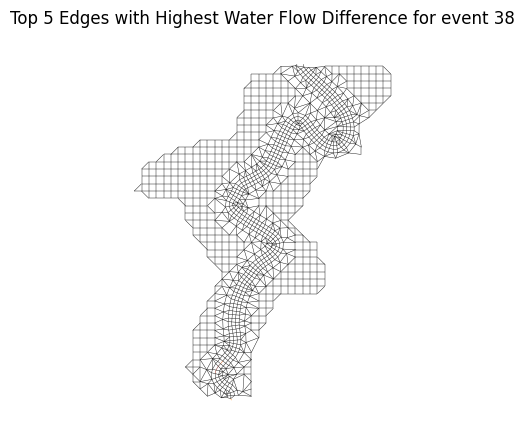

In [83]:
def get_highest_diff_water_flow_edges(dataset: FloodEventDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_edges = np.load(dynamic_edges_paths[event_idx])['dynamic_edges']
    water_flow_idx = FloodEventDataset.DYNAMIC_EDGE_FEATURES.index(FloodEventDataset.EDGE_TARGET_FEATURE)
    water_flow = dynamic_edges[:, :, water_flow_idx]
    water_flow = dataset.normalizer.denormalize(FloodEventDataset.EDGE_TARGET_FEATURE, water_flow)
    wf_diff = np.abs(np.diff(water_flow, axis=0))
    wf_diff_per_edge = wf_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wf_diff_per_edge)[-k:][::-1].tolist()
    top_k_wf_diff = wf_diff_per_edge[top_k_diff_idx]
    return top_k_diff_idx, top_k_wf_diff

def get_edge_df(dataset: FloodEventDataset, no_ghost: bool = True) -> gpd.GeoDataFrame:
    edges_shp_path = dataset.raw_paths[1]
    link_df = gpd.read_file(edges_shp_path)

    if no_ghost:
        bc = dataset.boundary_condition
        inflow_boundary_nodes = dataset.inflow_boundary_nodes
        outflow_boundary_nodes = dataset.outflow_boundary_nodes
        is_ghost_edge = link_df['from_node'].isin(bc.ghost_nodes) | link_df['to_node'].isin(bc.ghost_nodes)
        boundary_nodes = np.concat([np.array(dataset.inflow_boundary_nodes), np.array(dataset.outflow_boundary_nodes)])
        is_boundary_edge = link_df['from_node'].isin(boundary_nodes) | link_df['to_node'].isin(boundary_nodes)
        link_df = pd.concat([link_df[~is_ghost_edge], link_df[is_ghost_edge & is_boundary_edge]], ignore_index=True)

        assert np.all(link_df['from_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes) | link_df['to_node'][bc.inflow_edges_mask].isin(inflow_boundary_nodes)), "Inflow of link DataFrame does not match the inflow edges mask"
        assert np.all(link_df['from_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes) | link_df['to_node'][bc.outflow_edges_mask].isin(outflow_boundary_nodes)), "Outflow of link DataFrame does not match the outflow edges mask"

    return link_df

EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top edges to retrieve

top_k_diff_idx, top_k_wf_diff = get_highest_diff_water_flow_edges(dataset, EVENT_IDX, k=k)
print('Edges with the highest water flow difference:')
for idx, wf in zip(top_k_diff_idx, top_k_wf_diff):
    print(f"Edge {idx}: {wf:.2f} m")

edge_df = get_edge_df(dataset)
highlight = np.zeros(len(edge_df), dtype=object)
highlight[top_k_diff_idx] = top_k_diff_idx

plot_cell_map(edge_df, value=highlight, cmap=cmap)
plt.title(f'Top {k} Edges with Highest Water Flow Difference for event {dataset.hec_ras_run_ids[EVENT_IDX]}')
plt.show()

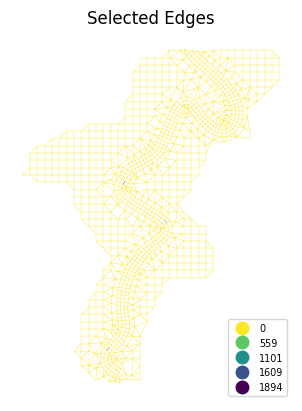

In [78]:
highlight_edge_idx = [1609, 1101, 1894, 559]
highlight = np.zeros(len(edge_df), dtype=object)
highlight[highlight_edge_idx] = highlight_edge_idx

plot_cell_map(edge_df, value=highlight, cmap='viridis_r', legend=True)
plt.title(f'Selected Edges')
plt.show()

In [56]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 27849.5664
	Std: 17814.3047
	Min: 0.0000
	Max: 117583.6875
aspect
	Mean: 176.5098
	Std: 104.6543
	Min: 0.0000
	Max: 359.8617
curvature
	Mean: 0.0002
	Std: 0.0005
	Min: 0.0000
	Max: 0.0085
elevation
	Mean: 105.5253
	Std: 43.6278
	Min: 0.0000
	Max: 319.1630
face_flow
	Mean: 12.0708
	Std: 273.7484
	Min: -4741.8276
	Max: 5704.7056
face_length
	Mean: 138.3993
	Std: 57.5719
	Min: 0.0000
	Max: 396.0271
flow_accumulation
	Mean: 1.6652
	Std: 1.5622
	Min: 0.0000
	Max: 15.0000
inflow
	Mean: 1188.4233
	Std: 1028.5288
	Min: 0.0000
	Max: 5704.7056
length
	Mean: 165.2975
	Std: 66.8252
	Min: 0.0000
	Max: 473.5640
position_x
	Mean: 318969.7500
	Std: 16519.0059
	Min: 0.0000
	Max: 323218.0625
position_y
	Mean: 6352800.0000
	Std: 327920.5000
	Min: 0.0000
	Max: 6373564.0000
rainfall
	Mean: 43.3244
	Std: 56.5489
	Min: 0.0000
	Max: 1198.1914
relative_position_x
	Mean: -13.9560
	Std: 125.9932
	Min: -398.5938
	Max: 424.3438
relative_position_y
	Mean: 28.5439
	Std: 122.0886
	Min:

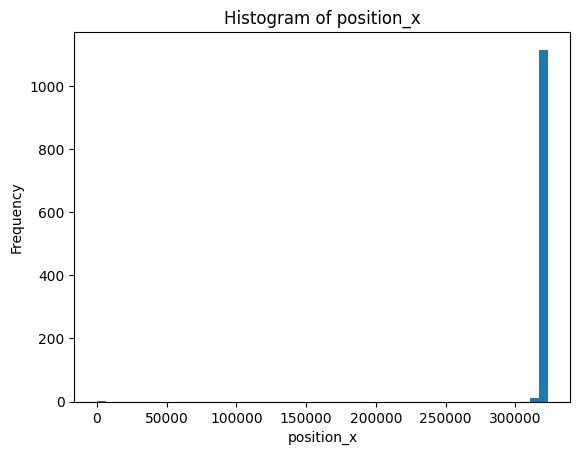

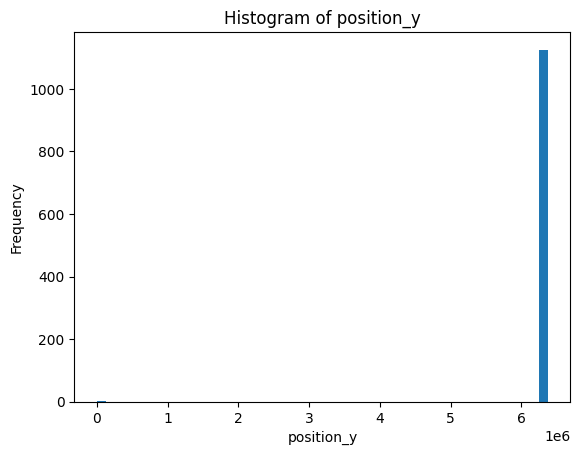

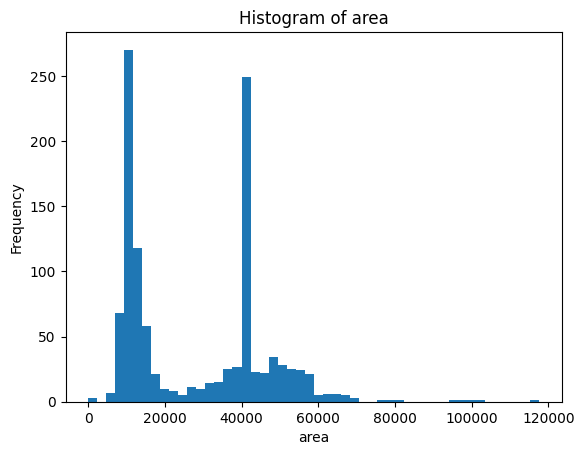

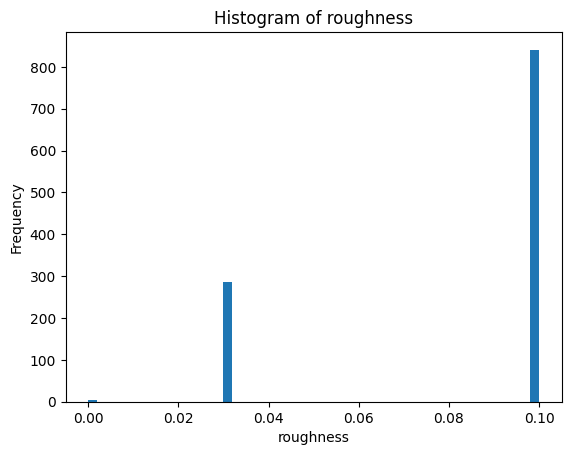

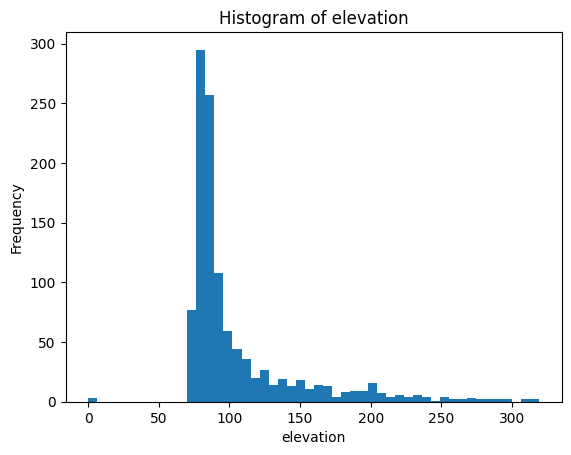

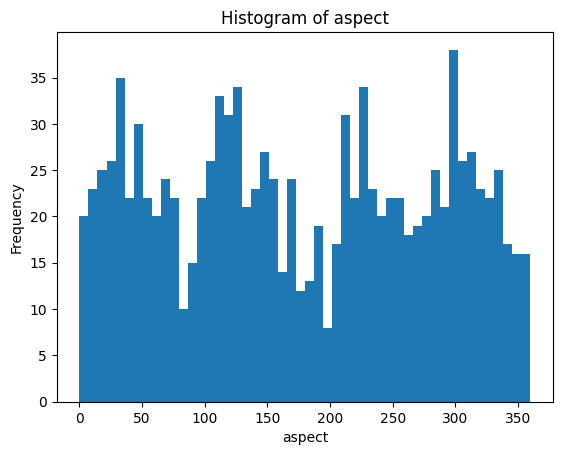

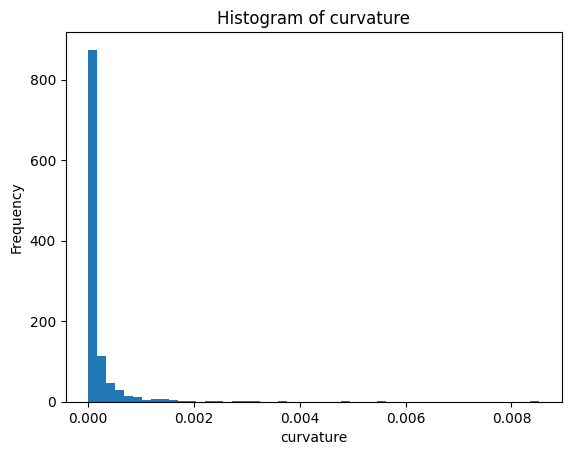

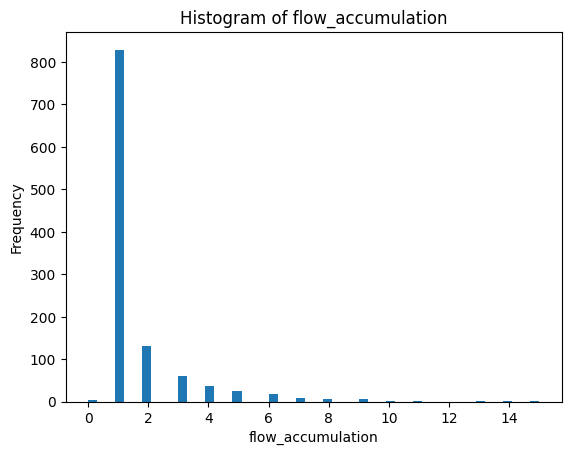

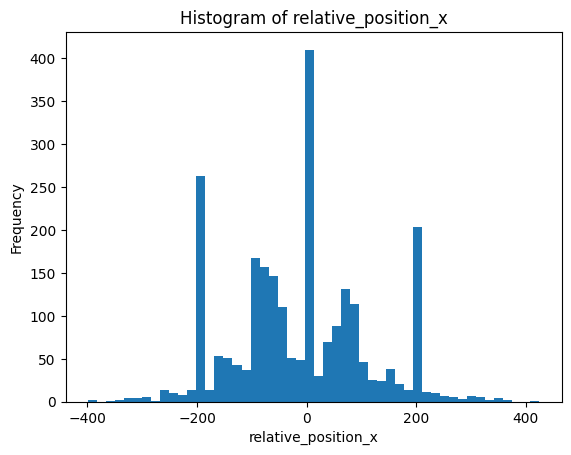

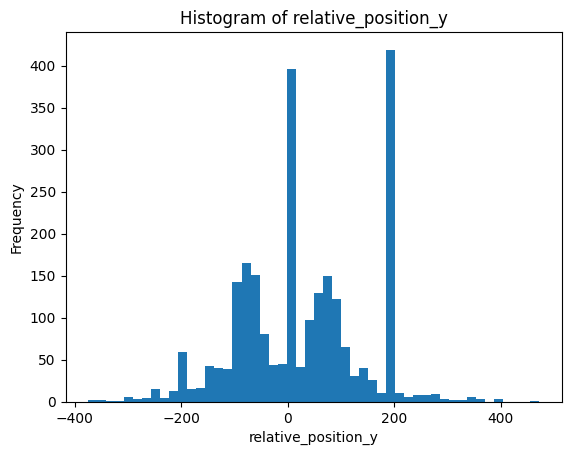

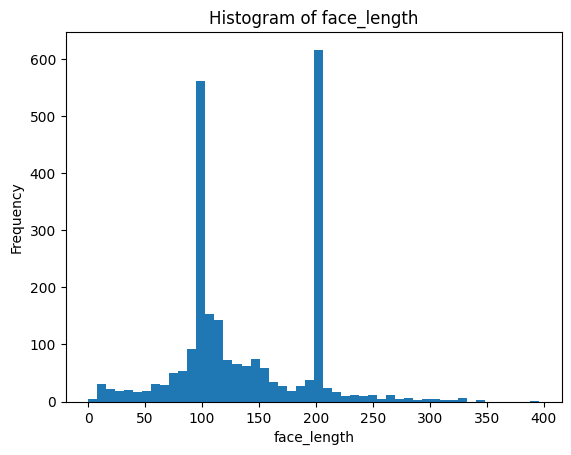

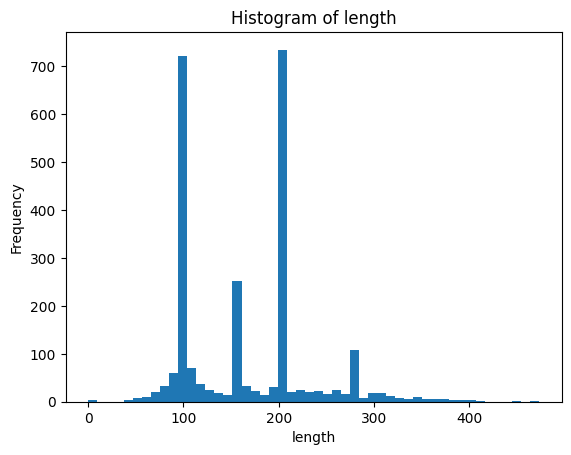

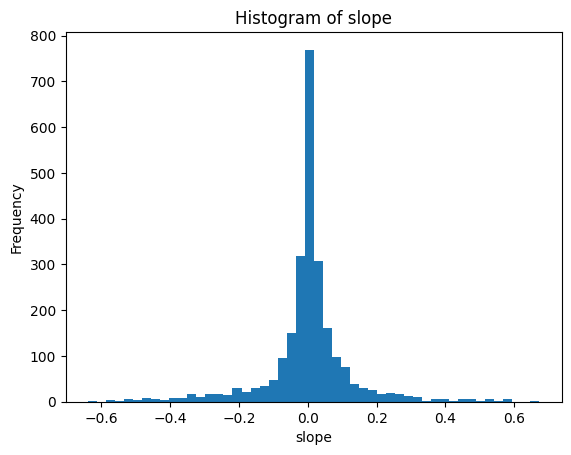

In [13]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEventDataset.STATIC_NODE_FEATURES + FloodEventDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

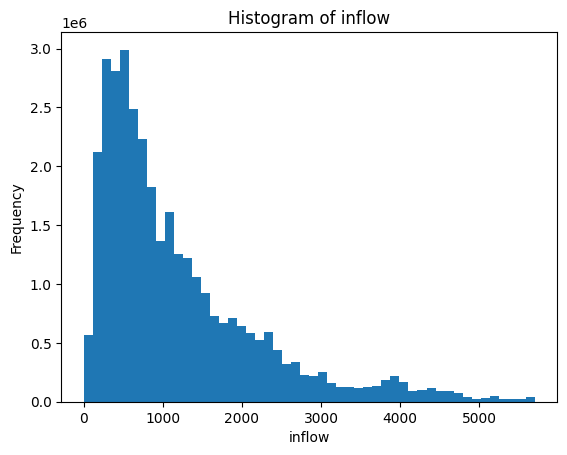

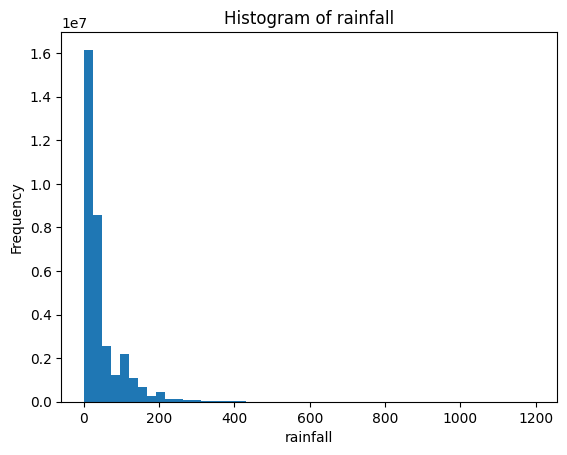

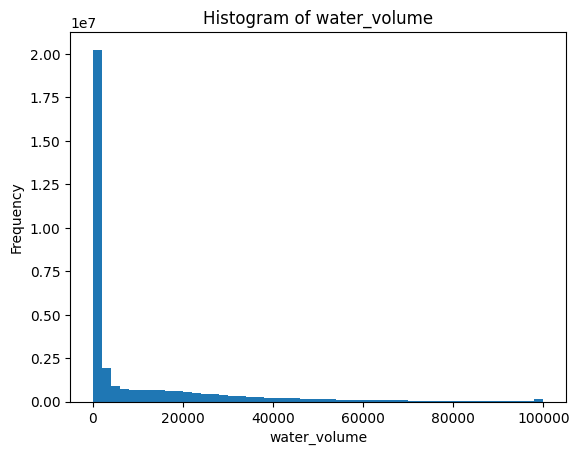

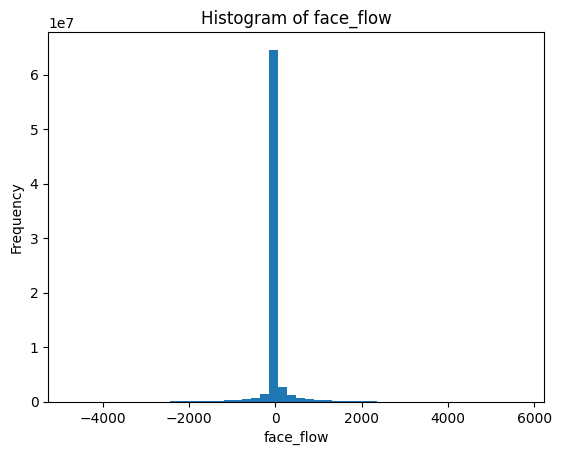

In [14]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEventDataset.DYNAMIC_NODE_FEATURES + FloodEventDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


In [15]:
# from scipy import stats

# num_events = len(dataset.hec_ras_run_ids)
# dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]


# feature = 'water_volume'
# index = FloodEventDataset.DYNAMIC_NODE_FEATURES.index(feature)
# key = 'dynamic_nodes'

# all_feature_data = []
# for path in dynamic_values_paths:
#     data = np.load(path)['dynamic_nodes']
#     feature_data = data[:, :, index]
#     if dataset.is_normalized:
#         feature_data = dataset.normalizer.denormalize(feature, feature_data)
#     all_feature_data.append(feature_data.flatten())
# all_feature_data = np.concatenate(all_feature_data)

# # Print summary statistics
# print(f'Statistics for {feature}:')
# print(f'\tTotal samples: {len(all_feature_data)}')
# print(f'\tMean: {np.mean(all_feature_data):.4f}')
# print(f'\tStd: {np.std(all_feature_data):.4f}')
# print(f'\tSkewness: {stats.skew(all_feature_data):.4f}')
# print(f'\tMin: {np.min(all_feature_data):.4f}')
# print(f'\tMax: {np.max(all_feature_data):.4f}')
# print(f'\tMedian: {np.median(all_feature_data):.4f}')
# print(f'\t25th Percentile: {np.percentile(all_feature_data, 25):.4f}')
# print(f'\t50th Percentile: {np.percentile(all_feature_data, 50):.4f}')
# print(f'\t75th Percentile: {np.percentile(all_feature_data, 75):.4f}')
# print(f'\t90th Percentile: {np.percentile(all_feature_data, 90):.4f}')
# print(f'\t99th Percentile: {np.percentile(all_feature_data, 99):.4f}')
# clip_value = 100000
# percentile = (all_feature_data < clip_value).sum() / len(all_feature_data) * 100
# print(f"\t{clip_value} is at the {percentile:.2f}th percentile")

# clipped_feature_data = all_feature_data[all_feature_data < clip_value]

# print(f'Statistics for {feature} (clipped at {clip_value}):')
# print(f'\tMean: {np.mean(clipped_feature_data):.4f}')
# print(f'\tSkewness: {stats.skew(clipped_feature_data):.4f}')
# print(f'\tMin: {np.min(clipped_feature_data):.4f}')
# print(f'\tMax: {np.max(clipped_feature_data):.4f}')
# print(f'\tMedian: {np.median(clipped_feature_data):.4f}')

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# axes[0].hist(all_feature_data, bins=bins)
# axes[0].set_title(f'Full Range')
# axes[0].set_xlabel('Water Volume (m³)')
# axes[0].set_ylabel('Frequency')

# axes[1].hist(clipped_feature_data, bins=bins)
# axes[1].set_title(f'Clipped at 100,000 m³')
# axes[1].set_xlabel('Water Volume (m³)')
# axes[1].set_ylabel('Frequency')

# fig.suptitle(f'Histograms of Water Volume (Full vs Clipped)')
# plt.tight_layout()
# plt.show()
